### This notebook will utilize a standard BERT model

### Just using the Title string as the feature

### The input to the neural network will be the pooled_token from BERT

### Output will be whether or not the question has a score of higher than 1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import pandas as pd

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.utils import class_weight

2022-12-01 00:05:08.399496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 00:05:08.645819: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 00:05:09.735551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-01 00:05:09.735654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
from transformers import RobertaTokenizer, TFRobertaModel
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

2022-12-01 00:05:14.622746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 00:05:14.656971: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-01 00:05:14.657012: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-01 00:05:14.658204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

In [3]:
# bring in the data
questions_data = pd.read_csv("processed_questions.csv")

In [4]:
# from sklearn.utils import shuffle
# questions_data = shuffle(questions_data)
# questions_data = questions_data.head(500) # just doing small subset to make it work at first

In [5]:
train, test = train_test_split(questions_data, test_size=0.2)

In [6]:
train_examples = list(train['Title'])
train_labels = list(train['has_positive_answer'])

In [7]:
test_examples = list(test['Title'])
test_labels = list(test['has_positive_answer'])

In [8]:
max_length = 20 # seems like this encompasses most titles

In [9]:
x_train = roberta_tokenizer(train_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = tf.convert_to_tensor(train_labels)

In [10]:
x_test = roberta_tokenizer(test_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = tf.convert_to_tensor(test_labels)

In [11]:
def create_roberta_classification_model(roberta_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    
    roberta_model.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    roberta_out = roberta_model(roberta_inputs)

    pooled_token = roberta_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [12]:
roberta_classification_model = create_roberta_classification_model(roberta_model, train_layers=-1)

In [13]:
roberta_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 20)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                           

In [14]:
y_train.numpy()

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [15]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights_dict = {}
for i in range(0,2):
    class_weights_dict[i] = class_weights[i]
class_weights_dict

{0: 1.518098755710545, 1: 0.7455557465302289}

In [16]:
roberta_classification_model_history = roberta_classification_model.fit(
    [x_train.input_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=1,
    class_weight=class_weights_dict
)  

15183/15183 [==============================] - 18226s 1s/step - loss: 0.6900 - accuracy: 0.5335 - val_loss: 0.6868 - val_accuracy: 0.5643


In [17]:
# how to make confusion matrix:
# https://androidkt.com/keras-confusion-matrix-in-tensorboard/

In [18]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
# how to save models

In [19]:
y_pred_raw = roberta_classification_model.predict([x_test.input_ids, x_test.attention_mask])

3796/3796 [==============================] - 3392s 890ms/step


In [20]:
y_pred = (y_pred_raw > 0.5).astype(int)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

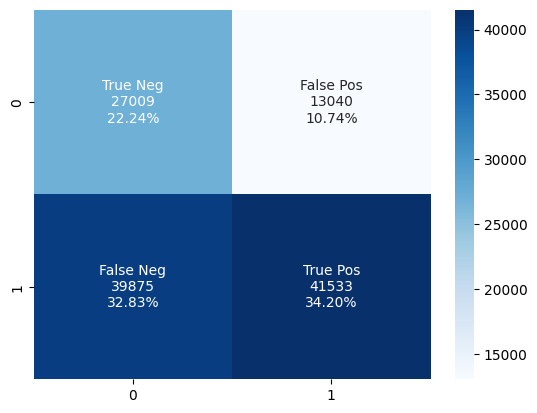

In [22]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

In [23]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_raw)
auc = metrics.roc_auc_score(y_test, y_pred_raw)

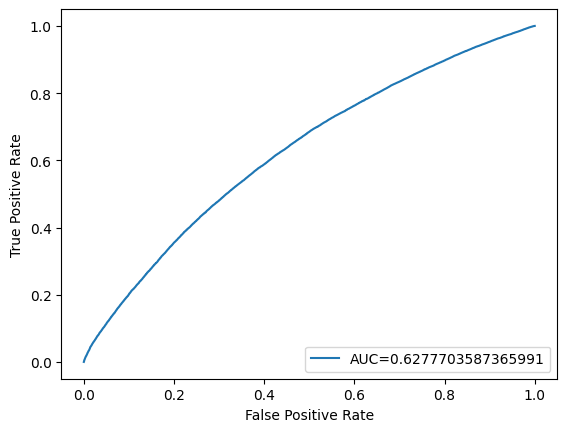

In [24]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [26]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.610864753164045
precision score is: 0.7610540010627966
recall score is: 0.5101832743710691
